# Άρης Τσιλιφώνης 1115201700170 
# Εργασία 2 τεχνητής νοημοσύνης 2(Natural language processing with Deep Learning)

### Import required libraries for the project

In [1]:
!python -m textblob.download_corpora
# For NN models
import torch.nn as nn
import torch
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
# Stop words
import nltk 
nltk.download('stopwords')  
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Necessary for data format
from sklearn.feature_extraction.text import CountVectorizer
# Word embedings
from sklearn.feature_extraction.text import TfidfVectorizer  
# Machine learning model
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Best parameters during classification
from sklearn.model_selection import GridSearchCV
# Data preprocessing
from sklearn.model_selection import train_test_split
# Validation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import torchtext
from torchtext.legacy import data

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load files to dataframes

In [3]:
df_train = pd.read_csv("/content/drive/My Drive/vaccine_train_set.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15976 entries, 0 to 15975
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15976 non-null  int64 
 1   tweet       15976 non-null  object
 2   label       15976 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 374.6+ KB


In [4]:
df_valid = pd.read_csv("/content/drive/My Drive/vaccine_validation_set.csv")

### Text processing for better perfomance

In [5]:
def tweet_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove non alphanumeric character
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # remove links
    text = re.sub(r'https?:/\/\S+', ' ', text)

    #apply blob techniques
    tweet_blob = TextBlob(text)
    #return normalized text
    blob_res = ' '.join(tweet_blob.words)
    #lematization techniques
    lemmatizer = WordNetLemmatizer() 
    #stop words definition
    stop_words = nltk.corpus.stopwords.words('english')
    #combine all previous methods in order to clear the text
    result = ' '.join(
       lemmatizer.lemmatize(term) 
       for term in text.split()
       if term not in set(stop_words)
    )
    return result

In [6]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(tweet_normalization)
    input_df.tweet = vfunc(input_df.tweet.values)
    # return processed input_df
    return input_df

In [7]:
df_train = preprocess(df_train)
df_train.head()

,Unnamed: 0,tweet,label
0,0,sip n shop come thru right marjais popularnobo...,0
1,1,know family take covid19 vaccine anytime soon,1
2,2,msignorile immunization mandatory period oklah...,2
3,3,president obama spoke favor vaccination child ...,0
4,4,myfoxla arizona monitoring hundred measles lin...,0


In [8]:
df_test = preprocess(df_valid)
df_test.head()

,Unnamed: 0,tweet,label
0,0,user massive surge covid death immediately vac...,1
1,1,required vaccine school parent guardian child ...,0
2,2,kcstar two johnson county child measles http c...,0
3,3,nv better state best worst vaccinating kid htt...,2
4,4,nothing like killing w fear mt alyssa milano v...,2


### Create format field for our dataset 

In [9]:
TWEET = data.Field(tokenize = 'spacy', include_lengths=True)

LABEL = data.LabelField(dtype = torch.float)

# define which fiels we are going to process
train_val_fields = [('tweet', TWEET),('label', LABEL)] # process it as tweet,label

testing

In [10]:
print(df_train.loc[[100]])

     Unnamed: 0                                tweet  label
100         100  psa vaccinate little dirty as child      2


### Create dataset

In [11]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False):
        examples = []
        # iterate all the rows in order to create the dataset dict
        for _, row in df.iterrows():
            label = row.label 
            tweet = row.tweet
            examples.append(data.Example.fromlist([tweet, label], fields))

        super().__init__(examples, fields)

    # class method in order to return the dataset in an apropriate from
    @classmethod
    def splits(cls, fields, train_df, test_df=None):
        train_data, test_data = (None, None)

        train_data = cls(train_df.copy(), fields)
        test_data = cls(test_df.copy(), fields, True)

        return tuple(d for d in (train_data, test_data))

In [12]:
train_df, test_df = DataFrameDataset.splits(train_val_fields, train_df=df_train, test_df=df_test)

In [13]:
print(vars(train_df[100]))

{'tweet': ['psa', 'vaccinate', 'little', 'dirty', 'as', 'child'], 'label': 2}


### Create vocabulary and its iterators

In [14]:
vocab_size = 20000
# build the vocabulary for both of the fields
TWEET.build_vocab(train_df,  max_size = vocab_size, vectors = 'glove.6B.50d', unk_init=torch.Tensor.normal_)

LABEL.build_vocab(train_df)

In [15]:
# preferebly use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the 2 iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train_df, test_df),batch_size = 128,sort= False, device = device)#I put small batches for better perfomance

In [16]:
len(TWEET.vocab)

20002

## Define Feed forward Neural Network model

In [17]:
class Sentiment_Model(nn.Module):
  # init function
  def __init__(self, input_size, embedding_neurons, hidden_neurons,output):
    # initialization of mother class
    super(Sentiment_Model, self).__init__()

    # embedding layer: input -> embeding [embedding layer for glove vectors]
    self.embedding = nn.Embedding(input_size, embedding_neurons)

    # 1st linear function: embeding -> hidden_neurons
    self.layer_1 = nn.Linear(embedding_neurons, hidden_neurons)
    # activation function for 1st layer
    self.relu_1 = nn.ReLU()

    # output layer: hidden_neurons -> 3 neuros (classification)
    self.output = nn.Linear(hidden_neurons, output)
    # activation using the sigmoid function
    self.activation =  nn.Sigmoid()
 

  def forward(self, x, lengths):

    out = self.embedding(x).sum(dim=0)

    out = self.layer_1(out)
    out = self.relu_1(out)

    out = self.output(out)
    out = self.activation(out)

    return out

### Initialize parameters

In [18]:
#Define layer sizes
D_in = len(TWEET.vocab)
embedding_neuros = len(TWEET.vocab.vectors[0])
H = 128
D_out = 3

# #Define Hyperparameters
learning_rate = 0.01

#Initialize model, loss, optimizer
model = Sentiment_Model(D_in,embedding_neuros,H, D_out)
loss_func = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# initialize the weights
model.embedding.weight.data.copy_(TWEET.vocab.vectors)

tensor([[-0.4595, -1.0170, -0.3225,  ..., -3.0707,  0.7460,  0.3085],
        [ 0.2526,  0.9939,  0.1907,  ...,  1.0561,  2.7283, -0.0338],
        [ 1.2358, -0.0211,  0.5030,  ...,  0.6742,  0.2743, -0.2233],
        ...,
        [ 0.4312, -0.9816,  0.0041,  ...,  1.1172, -0.3061, -1.4230],
        [ 0.1534, -1.2581,  2.3579,  ...,  0.3486,  0.1710,  0.0486],
        [-1.1669,  1.3459, -0.9558,  ...,  0.1423, -2.1708, -1.4410]])

### Loss function and accuracy score require binary format

In [19]:
def one_hot_encoder(train_labels):
    onehot_encoded = list()
    for value in train_labels:
      letter = [float(0) for _ in range(3)]
      letter[int(value)] = float(1)
      onehot_encoded.append(letter)
    return np.array(onehot_encoded)

### Training function 

In [20]:
def eval_model(model, iterator, optimizer, loss, flag):

  epoch_loss = 0
  epoch_accuracy = 0
  # hold the n of items in the iterator in order to return the mean loss and accuracy
  items = 0
  epoch_recall = 0
  epoch_f1 = 0

  # do training only on training set
  if(flag==0):
    model.train()
  
  for batch in iterator:
    items += 1
    # get text info
    tweet, len = batch.tweet
    # clear gradients
    optimizer.zero_grad()

    # forward propagation
    outputs = model.forward(tweet, len)
    
    #print(outputs)
    yprev_batch = batch.label
    batch.label = one_hot_encoder(batch.label)
    # model requires data as tensors
    batch.label = torch.as_tensor(batch.label, dtype=torch.float32)
    #print(batch.label)

    # compute loss
    ret_loss = loss(outputs, batch.label)
    # compute accuracy
    # one hot encoding for predictions
    y_pred = torch.argmax(outputs,dim=1)    
    y_pred = torch.as_tensor(y_pred, dtype=torch.int32)
    yprev_batch = torch.flatten(yprev_batch)
    yprev_batch = torch.as_tensor(yprev_batch, dtype=torch.int32)
    metrics_list = precision_recall_fscore_support( yprev_batch ,y_pred, average='weighted',warn_for=tuple())

    # pass gradients back, startiing on loss value
    ret_loss.backward()
    # update parameters
    optimizer.step()
    # compute loss and accuracy
    epoch_loss += ret_loss.item()
    epoch_accuracy += metrics_list[0]
    epoch_recall +=  metrics_list[1]
    epoch_f1 += metrics_list[2]

  return round(epoch_loss/items,4),round(epoch_accuracy/items,4),round(epoch_recall/items,4),round(epoch_f1/items,4)

### Training with epochs

In [21]:
def train(model, epochs, optimizer, iterator, loss,flag):
  losses = []
  epoch_accuracy = []

  for epoch in range(epochs):
    epoch_loss, epoch_accuracy , epoch_recall ,epoch_f1 = eval_model(model, iterator, optimizer, loss,flag)
    print("Epoch: ", epoch, " loss: ", round(epoch_loss,4), " precision: ", round(epoch_accuracy, 4), " recall: ", round(epoch_recall, 4), " f1_score ", round(epoch_f1, 4))
    losses.append(epoch_loss)

  return losses,epoch_accuracy

In [22]:
losses,_ = train(model, 20, optimizer, train_iterator, loss_func,0)

Epoch:  0  loss:  136.6654  precision:  0.2186  recall:  0.4649  f1_score  0.2967
Epoch:  1  loss:  136.288  precision:  0.22  recall:  0.4669  f1_score  0.2985
Epoch:  2  loss:  136.288  precision:  0.2198  recall:  0.4667  f1_score  0.2983
Epoch:  3  loss:  136.288  precision:  0.2195  recall:  0.467  f1_score  0.2982
Epoch:  4  loss:  136.288  precision:  0.2199  recall:  0.4668  f1_score  0.2984
Epoch:  5  loss:  136.288  precision:  0.22  recall:  0.4666  f1_score  0.2984
Epoch:  6  loss:  136.288  precision:  0.2201  recall:  0.4668  f1_score  0.2985
Epoch:  7  loss:  136.288  precision:  0.2194  recall:  0.4668  f1_score  0.2981
Epoch:  8  loss:  136.288  precision:  0.2199  recall:  0.4667  f1_score  0.2983
Epoch:  9  loss:  136.288  precision:  0.2196  recall:  0.4667  f1_score  0.2982
Epoch:  10  loss:  136.288  precision:  0.2206  recall:  0.4668  f1_score  0.2988
Epoch:  11  loss:  136.288  precision:  0.2205  recall:  0.4669  f1_score  0.2988
Epoch:  12  loss:  136.288  pr

# Diagram MSE/epochs (y/x)

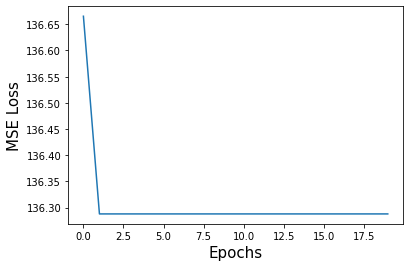

In [23]:
plt.plot(losses)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("MSE Loss", fontsize=15)
plt.show()

### Define second model

In [24]:
#Define layer sizes
D_in = len(TWEET.vocab)
embedding_neuros = 50
H = 256
D_out = 3

# #Define Hyperparameters
learning_rate = 0.003

#Initialize model, loss, optimizer
model2 = Sentiment_Model(D_in,embedding_neuros,H, D_out)
loss_func =  nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# initialize the weights
model.embedding.weight.data.copy_(TWEET.vocab.vectors)

tensor([[-0.4595, -1.0170, -0.3225,  ..., -3.0707,  0.7460,  0.3085],
        [ 0.2526,  0.9939,  0.1907,  ...,  1.0561,  2.7283, -0.0338],
        [ 1.2358, -0.0211,  0.5030,  ...,  0.6742,  0.2743, -0.2233],
        ...,
        [ 0.4312, -0.9816,  0.0041,  ...,  1.1172, -0.3061, -1.4230],
        [ 0.1534, -1.2581,  2.3579,  ...,  0.3486,  0.1710,  0.0486],
        [-1.1669,  1.3459, -0.9558,  ...,  0.1423, -2.1708, -1.4410]])

In [25]:
losses,accuracies = train(model2, 20, optimizer, train_iterator, loss_func,0)

Epoch:  0  loss:  0.7515  precision:  0.5301  recall:  0.5346  f1_score  0.4768
Epoch:  1  loss:  0.4691  precision:  0.6537  recall:  0.6606  f1_score  0.6312
Epoch:  2  loss:  0.4088  precision:  0.7307  recall:  0.7236  f1_score  0.7045
Epoch:  3  loss:  0.3554  precision:  0.7741  recall:  0.7638  f1_score  0.752
Epoch:  4  loss:  0.3231  precision:  0.8084  recall:  0.7968  f1_score  0.7881
Epoch:  5  loss:  0.294  precision:  0.8309  recall:  0.8143  f1_score  0.809
Epoch:  6  loss:  0.2468  precision:  0.8658  recall:  0.8544  f1_score  0.8515
Epoch:  7  loss:  0.2191  precision:  0.882  recall:  0.8728  f1_score  0.8703
Epoch:  8  loss:  0.1998  precision:  0.8992  recall:  0.8859  f1_score  0.8835
Epoch:  9  loss:  0.1604  precision:  0.9148  recall:  0.9085  f1_score  0.9077
Epoch:  10  loss:  0.1357  precision:  0.9315  recall:  0.9266  f1_score  0.926
Epoch:  11  loss:  0.1296  precision:  0.9369  recall:  0.9314  f1_score  0.9306
Epoch:  12  loss:  0.1167  precision:  0.94

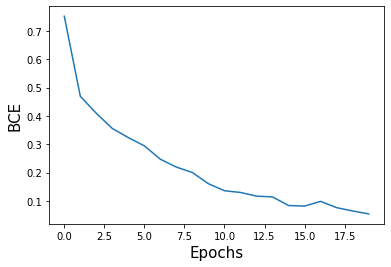

In [26]:
plt.plot(losses)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("BCE", fontsize=15)
plt.show()

In [27]:
prec_score_test = np.mean(accuracies)
print(prec_score_test)

0.9755


In [28]:
print(len(test_df))

2282


In [29]:
test_iterator = data.BucketIterator(test_df, batch_size=2282, device=device)

### Test model

In [30]:
def test_epoch(model, iterator):

  epoch_loss = 0
  epoch_accuracy = 0
  # hold the n of items in the iterator in order to return the mean loss and accuracy
  items = 0
  epoch_recall = 0
  epoch_f1 = 0
  
  for batch in iterator:
    items += 1
    # get text info
    tweet, len = batch.tweet

    # forward probagation
    outputs = model.forward(tweet, len)
    
    y_pred_test = torch.argmax(outputs,dim=1)
    Y_test = batch.label
    print(y_pred_test)
    print(batch.label)
    Y_test = torch.flatten(Y_test)
    Y_test = torch.as_tensor(Y_test, dtype=torch.int32)
    
    print("Accuracy score: {}".format(round(accuracy_score(Y_test ,y_pred_test),2)))
    print(classification_report(Y_test,y_pred_test))    

    return Y_test,y_pred_test,outputs

Same testing as tf-idf(same testing pool)

In [31]:
Y_test,y_pred_test,outputs = test_epoch(model2, test_iterator)

tensor([0, 0, 0,  ..., 1, 0, 1])
tensor([1., 0., 2.,  ..., 1., 0., 1.])
Accuracy score: 0.65
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      1065
           1       0.66      0.55      0.60       921
           2       0.49      0.47      0.48       296

    accuracy                           0.65      2282
   macro avg       0.61      0.60      0.60      2282
weighted avg       0.64      0.65      0.64      2282



## Confusion matrix

In [32]:
C = np.array(confusion_matrix(Y_test ,y_pred_test))

confmtrx = pd.DataFrame(C, index=['neutral, true','anti-vax, true','pro-vax, true'],
columns=['neutral, predicted','anti-vax, predicted','pro-vax, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
    
confmtrx

,"neutral, predicted","anti-vax, predicted","pro-vax, predicted",sum
"neutral, true",831,177,57,1065
"anti-vax, true",329,505,87,921
"pro-vax, true",77,81,138,296
sum,1237,763,282,2282


## ROC Scores

In [33]:
import sklearn.metrics as metrics

probs = outputs

# keep probabilities for the positive outcome only
ns_probs = [[0,0,0] for _ in range(len(Y_test))]

print(Y_test)
Y_testb = one_hot_encoder(Y_test)
Y_testb = torch.as_tensor(Y_testb, dtype=torch.float32)

print(Y_testb)
probs = torch.argmax(probs,dim=1)
probs = one_hot_encoder(probs)
probs = torch.as_tensor(probs, dtype=torch.float32)
print(probs)

ns_auc = roc_auc_score(Y_testb, ns_probs, multi_class="ovr")
lr_auc = roc_auc_score(Y_testb, probs, multi_class="ovr")

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

tensor([1, 0, 2,  ..., 1, 0, 1], dtype=torch.int32)
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.700


### ROC Curves

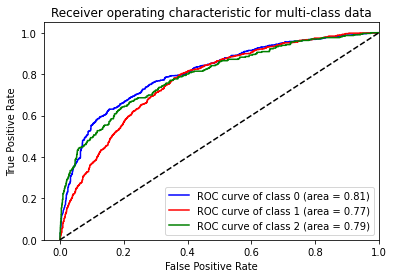

In [34]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

predict_outs = outputs
predict_outs = predict_outs.detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_testb[:, i],predict_outs[:, i] )
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()